In [1]:
import sys; sys.path.insert(0, '..')

from gquant.dataframe_flow import TaskGraph

In [2]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:36927 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


We can open the status page in the brwoser by following javascript commands

In [3]:
from IPython.display import HTML
javascript = """
<script type="text/Javascript">
    function check_status(){
        var url = document.location.href;
        var index = url.indexOf(':8888');
        var status = url.substr(0, index)+":8787";
        window.open(status,'_blank');
    }
    check_status();
</script>
"""
HTML(javascript)

# Prepare distributed CSV files <span style="color:red">(not necessary if the dataset is already prepared)</span>

Following is the code to prepare the dataset as mulitple csv files that we can use dask_cuda to load them

In [6]:
import dask.dataframe as dd
import os
action = "load" if os.path.isfile('./.cache/load_csv_data.hdf5') else "save"
node_csv = {"id": "load_csv_data",
            "type": "CsvStockLoader",
            "conf": {"path": "/Project/data/stocks/stock_price_hist.csv.gz"},
            "inputs": []}

node_sort = {"id": "node_sort",
             "type": "SortNode",
             "conf": {"keys": ['asset', 'datetime']},
             "inputs": ["load_csv_data"]}
task_graph = TaskGraph([node_csv, node_sort])
df = task_graph.run(
         outputs=['node_sort'],
         replace={'load_csv_data': {action: True}})[0]
os.makedirs('many-small', exist_ok=True)
print(df)
df = dd.from_pandas(df.to_pandas(), npartitions=8).to_csv('many-small/*.csv', index=False)

           datetime    open   close    high     low   asset  volume
1870     1990-01-02    1.12    1.12    1.12    1.12      93     0.0
1871     1990-01-03    1.00    1.00    1.00    1.00      93    15.6
1872     1990-01-04    1.00    1.00    1.00    1.00      93     0.0
1873     1990-01-05    1.00    1.00    1.00    1.00      93     0.0
1874     1990-01-08    1.00    1.00    1.00    1.00      93     0.6
1875     1990-01-09    1.00    1.00    1.00    1.00      93     0.0
1876     1990-01-10    1.00    1.00    1.00    1.00      93     0.0
1877     1990-01-11    1.12    1.12    1.12    1.12      93     1.6
1878     1990-01-12    1.12    1.12    1.12    1.12      93     0.0
1879     1990-01-15    1.00    1.00    1.00    1.00      93     1.2
1880     1990-01-16    1.00    1.00    1.00    1.00      93     0.0
1881     1990-01-17    1.00    1.00    1.00    1.00      93     0.0
1882     1990-01-18    1.00    1.00    1.00    1.00      93     0.0
1883     1990-01-19    1.00    1.00    1.00    1

In [4]:
!cat ../task_example/dask_task.yaml

- id: node_csvdata_dask
  type: DaskCsvStockLoader
  conf:
    path: many-small
  inputs: []
- id: node_minVolume
  type: VolumeFilterNode
  conf:
    min: 50.0
  inputs: 
    - node_csvdata_dask
- id: node_sort
  type: SortNode
  conf:
    keys: 
      - asset
      - datetime
  inputs: 
    - node_minVolume
- id: node_volumeMean
  type: AverageNode
  conf:
    column: volume
  inputs: 
    - node_sort
- id: node_outputCsv
  type: OutCsvNode
  conf:
    path: symbol_volume.csv
  inputs:
    - node_volumeMean


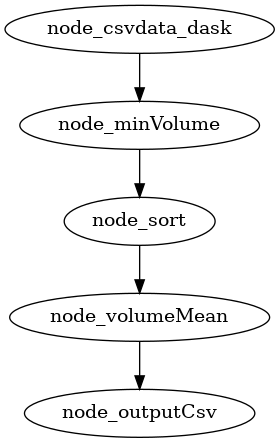

In [5]:
task_graph = TaskGraph.load_taskgraph('../task_example/dask_task.yaml')
task_graph.draw(show='ipynb')

In [6]:
df = task_graph.run(['node_outputCsv'], {}, profile=True)[0]

id:node_csvdata_dask process time:0.738
id:node_minVolume process time:0.668
id:node_volumeMean process time:0.124
id:node_outputCsv process time:1.708


In [7]:
df

,asset,volume
0,631,350.187622
1,914,267.823241
2,1404,2073.026646
3,1544,80.645555
4,1545,18920.967128
5,1551,137.250647
6,1556,255.882891
7,1562,185.334286
8,1565,66.781550
9,1568,948.372821
